# Setup

In [1]:
pip install -r ../../requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

In [3]:
# Add directory above current directory to path
import sys

sys.path.insert(0, '../..')

In [5]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import pandas as pd
import numpy as np
import json
from utils.text_processing import CharTokenizer

In [6]:
if tf.config.list_physical_devices('GPU'):
    tf.config.experimental.get_memory_info("GPU:0")

2023-06-14 18:00:40.378105: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-14 18:00:40.930498: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-06-14 18:00:40.930552: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30967 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:3a:00.0, compute capability: 7.0


In [7]:
config = json.load(open("./configs/mnn_btl_bert_amazon_lr_1e-05.json"))

# Loading data

In [8]:
from data_loader.abo import ABO

In [9]:
data = ABO(path=config["data"]["path"],
           download=True,
           extract=False,
           preprocess=True,
           alt_augment=False,
           random_deletion=False,
           export_csv=True).data

# data = pd.read_csv(os.path.join(config["data"]["path"], "data.csv"))
# data = data.drop({"Unnamed: 0"}, axis=1)

data = data[['description', 'path', 'product_type', 'label']]
data

abo-listings.tar already exists.
abo-images-small.tar already exists.
Loading images...
Loading texts...
Importing listings CSV...
Creating false samples/complement...
Merging ground truth and complement...
Concatenating attributes into description columns...
Finishing up...
Exporting to CSV...
Data processing complete


,description,path,product_type,label
0,back coverb0854lm94tamazon brand - solimo desi...,35/35f0a7ac.jpg,CELLULAR_PHONE_CASE,1
1,mobile coverb072n7ggkbamazon brand - solimo de...,0f/0ff62b3e.jpg,FINENECKLACEBRACELETANKLET,0
2,mobile coverb0854775hpamazon brand - solimo de...,62/62fa7e36.jpg,SHOES,0
3,mobile coverb07tf1d7jgamazon brand - solimo de...,c0/c0bfa0d3.jpg,CELLULAR_PHONE_CASE,1
4,mobile coverb07tcwrmj7amazon brand - solimo de...,a6/a6aa41af.jpg,CELLULAR_PHONE_CASE,0
...,...,...,...,...
168202,mobile coverb081hmphvtamazon brand - solimo de...,ea/eaeeefdd.jpg,CELLULAR_PHONE_CASE,1
168203,back coverb07fnbjw24amazon brand - solimo desi...,db/dbb1be1e.jpg,PORTABLE_ELECTRONIC_DEVICE_COVER,0
168204,mobile coverb07th3ccxmamazon brand - solimo de...,87/87f570ad.jpg,CELLULAR_PHONE_CASE,1
168205,formal shoes for mens leatherb07tg4wgvbamazon ...,4c/4cfdeb1f.jpg,CELLULAR_PHONE_CASE,0


In [10]:
img = data[["path"]]  # two brackets for keeping the column name
text = data["description"]
product_types = data[["product_type"]]
labels = data[["label"]]

# Text processing

The following part is largely based off of https://www.tensorflow.org/text/guide/bert_preprocessing_guide

## generate text embeddings directly with BERT

In [24]:
bert_model_name = 'bert_en_uncased_L-12_H-768_A-12' 

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [25]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [26]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [27]:
# text = bert_preprocess_model(text)

# print(f'Keys       : {list(text.keys())}')
# print(f'Shape      : {text["input_word_ids"].shape}')
# print(f'Word Ids   : {text["input_word_ids"][0, :12]}')
# print(f'Input Mask : {text["input_mask"][0, :12]}')
# print(f'Type Ids   : {text["input_type_ids"][0, :12]}')

In [28]:
# text

In [29]:
# text = bert_model(text)

# print(f'Loaded BERT: {tfhub_handle_encoder}')
# print(f'Pooled Outputs Shape:{text["pooled_output"].shape}')
# print(f'Pooled Outputs Values:{text["pooled_output"][0, :12]}')
# print(f'Sequence Outputs Shape:{text["sequence_output"].shape}')
# print(f'Sequence Outputs Values:{text["sequence_output"][0, :12]}')

In [30]:
# text = text["pooled_output"]
# text.shape

# Image processing

## Load image model

In [18]:
from utils.img_processing import load_img_model, create_embeddings_from

In [19]:
img_model = load_img_model(config["img_model"])

img_model.output_shape

(None, 576)

## Create image embeddings

In [ ]:
# Mobilenetv3small:
# batch_size = 1024 -> 8 GB VRAM
# batch_size = 2048 -> 16 GB VRAM
# ...
# Mobilenetv3large: twice as much as Mobilenetv3small

img = create_embeddings_from(img_model,
                             img,
                             os.path.join(config["data"]["path"],
                                          "images/small"),
                             batch_size=1024)

Found 168171 validated image filenames.


In [15]:
img.shape

(168171, 576)

# Save embeddings

In [31]:
save_path = os.path.join(config["data"]["path"],
                         f"embeddings/bert/{img_model.name}")

In [32]:
os.makedirs(save_path, exist_ok=True)
np.save(f"{save_path}/img.npy", img)
np.save(f"{save_path}/text.npy", text)
data.to_csv(f"{save_path}/data.csv")

## Verify import

In [57]:
data = pd.read_csv(f"{save_path}/data.csv")
data = data.drop({"Unnamed: 0"}, axis=1)
data

,description,description2,path,product_type,label
0,shoesb0791vjhksamazon brand - symbol men's sne...,shoesb0791vjhksamazon brand - symbol men's sne...,4d/4d552519.jpg,SHOES,1
1,mobile coverb07tg4cyjvamazon brand - solimo de...,mobile coverb07tg4cyjvamazon brand - solimo de...,4d/4de76f7f.jpg,CELLULAR_PHONE_CASE,1
2,"mobile coverb0856b8fw1sunshine swatch, ravenna...",combo cooker dutch oven for bread making ovens...,72/72c5b6c9.jpg,GROCERY,0
3,"whole foods, whole food, whole foods,365 every...",cellphonecoverb07tf7gr3ywhole foods market cre...,85/854b1468.jpg,CELLULAR_PHONE_CASE,0
4,back coverb00no73q84amazon brand - solimo desi...,mobile coverb071gvmr85amazon brand - solimo de...,6a/6a127d3e.jpg,BOOT,0
...,...,...,...,...,...
168221,mobile coverb07y33f9kxamazon brand - solimo de...,handbags for women latest brandedb072kwqy8yama...,e6/e6ed7731.jpg,CELLULAR_PHONE_CASE,0
168222,amazonbasics;amzn-lt800p-a;replacement-refrige...,amazonbasics;amzn-lt800p-a;replacement-refrige...,73/73903c65.jpg,MAJOR_HOME_APPLIANCES,1
168223,placeholderb074h67h9qamazon brand - solimo des...,deb0854kjcylamazon brand - solimo designer cou...,10/10b2c3af.jpg,CELLULAR_PHONE_CASE,0
168224,mobile coverb0854ljhw2half tofu banh mi,mobile coverb081hmxdkvfind. women's velvet str...,de/de19c121.jpg,GROCERY,0


In [58]:
img = np.load(f"{save_path}/img.npy", allow_pickle=True)
img.shape

(168226, 576)

In [59]:
text = np.load(f"{save_path}/text.npy", allow_pickle=True)
text.shape

(168226,)

# Train-Test Split

## Split into ground truth/false samples

To use `stratify` parameter of `sklearn.model_selection.train_test_split()`, we need to select all product instances which appear more than once

In [60]:
ground_truth = data[data["label"] == 1]
false_samples = data[data["label"] == 0]
data = ground_truth
data

,description,description2,path,product_type,label
0,shoesb0791vjhksamazon brand - symbol men's sne...,shoesb0791vjhksamazon brand - symbol men's sne...,4d/4d552519.jpg,SHOES,1
1,mobile coverb07tg4cyjvamazon brand - solimo de...,mobile coverb07tg4cyjvamazon brand - solimo de...,4d/4de76f7f.jpg,CELLULAR_PHONE_CASE,1
6,samsung m31 360 coverb08563mt9famazon brand - ...,samsung m31 360 coverb08563mt9famazon brand - ...,cc/cc1f9aef.jpg,CELLULAR_PHONE_CASE,1
8,mobile coverb07tg44qnnamazon brand - solimo de...,mobile coverb07tg44qnnamazon brand - solimo de...,6b/6be7b7d0.jpg,CELLULAR_PHONE_CASE,1
12,mobile coverb07t22ks83amazon brand - solimo de...,mobile coverb07t22ks83amazon brand - solimo de...,04/04287092.jpg,CELLULAR_PHONE_CASE,1
...,...,...,...,...,...
168216,back coverb0854ctp5namazon brand - solimo desi...,back coverb0854ctp5namazon brand - solimo desi...,03/03f0cbf6.jpg,CELLULAR_PHONE_CASE,1
168217,mobile coverb081hnqrqjamazon brand - solimo de...,mobile coverb081hnqrqjamazon brand - solimo de...,67/67d2b3f8.jpg,CELLULAR_PHONE_CASE,1
168219,shoes for women stylishb07xrx83cmamazon brand ...,shoes for women stylishb07xrx83cmamazon brand ...,d7/d77cc014.jpg,SHOES,1
168220,arena strength pilates band resistance bands s...,arena strength pilates band resistance bands s...,d3/d3e492c8.jpg,EXERCISE_BAND,1


In [61]:
false_samples

,description,description2,path,product_type,label
2,"mobile coverb0856b8fw1sunshine swatch, ravenna...",combo cooker dutch oven for bread making ovens...,72/72c5b6c9.jpg,GROCERY,0
3,"whole foods, whole food, whole foods,365 every...",cellphonecoverb07tf7gr3ywhole foods market cre...,85/854b1468.jpg,CELLULAR_PHONE_CASE,0
4,back coverb00no73q84amazon brand - solimo desi...,mobile coverb071gvmr85amazon brand - solimo de...,6a/6a127d3e.jpg,BOOT,0
5,back coverb07t9tlvvzamazonbasics youth basebal...,mobile coverb0856b4tqqamazon brand - solimo de...,ec/ec078182.jpg,HOME,0
7,mobile coverb07tg4m9mbamazon brand -rivet midt...,cellphonecoverb07tg3nw24amazon brand - solimo ...,e7/e740caed.jpg,CELLULAR_PHONE_CASE,0
...,...,...,...,...,...
168218,classics with a twistb07z43sk54amazon brand - ...,pancake syrupb0857kv499amazon brand - solimo d...,05/05fa30f2.jpg,CELLULAR_PHONE_CASE,0
168221,mobile coverb07y33f9kxamazon brand - solimo de...,handbags for women latest brandedb072kwqy8yama...,e6/e6ed7731.jpg,CELLULAR_PHONE_CASE,0
168223,placeholderb074h67h9qamazon brand - solimo des...,deb0854kjcylamazon brand - solimo designer cou...,10/10b2c3af.jpg,CELLULAR_PHONE_CASE,0
168224,mobile coverb0854ljhw2half tofu banh mi,mobile coverb081hmxdkvfind. women's velvet str...,de/de19c121.jpg,GROCERY,0


In [62]:
img_false = img[false_samples.index]
text_false = text[false_samples.index]

In [63]:
img = img[data.index]
text = text[data.index]

In [64]:
data = data.reset_index(drop=True)
false_samples = false_samples.reset_index(drop=True)

In [65]:
img.shape

(87380, 576)

In [66]:
img_false.shape

(80846, 576)

## Ground truth

In [67]:
data["product_type_count"] = data.groupby(
    ["product_type"])["product_type"].transform("count")

data = data[data["product_type_count"] > config["data"]["cls"]]

In [68]:
# Update both columns
product_types = data[["product_type"]]

labels = data[["label"]]

In [69]:
from sklearn.model_selection import train_test_split

In [70]:
train, test, product_types_train, product_types_test = train_test_split(
    data,
    product_types,
    stratify=product_types,
    test_size=config["model"]["training"]["test_split"],
    random_state=42)

In [71]:
img_train = img[train.index]
img_test = img[test.index]

text_train = text[train.index]
text_test = text[test.index]

## False samples

In [72]:
false_samples["product_type_count"] = false_samples.groupby(
    ["product_type"])["product_type"].transform("count")

false_samples = false_samples[false_samples["product_type_count"] > config["data"]["cls"]]

In [73]:
# Update both columns
product_types_false = false_samples[["product_type"]]

labels_false = false_samples[["label"]]

In [74]:
from sklearn.model_selection import train_test_split

In [75]:
train_false, test_false, product_types_train_false, product_types_test_false = train_test_split(
    false_samples,
    product_types_false,
    stratify=product_types_false,
    test_size=config["model"]["training"]["test_split"],
    random_state=42)

In [76]:
img_train_false = img_false[train_false.index]
img_test_false = img_false[test_false.index]

text_train_false = text_false[train_false.index]
text_test_false = text_false[test_false.index]

# Build MNN-BTL Model

In [77]:
from utils.metrics import create_metrics

In [78]:
head_config = {
    "img_input_size": img_model.layers[-1].output_shape[1],
    "txt_input_size": config["data"]["input_size"],
    "img_fc_layers": config["model"]["img_fc_layers"],
    "txt_fc_layers": config["model"]["txt_fc_layers"],
    "extended": False,
}

In [79]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Lambda, Concatenate, Embedding, Flatten
from tensorflow.keras.optimizers import Adam
from models.mnn_em import _CNNBranch
from models.addons.tensorflow_addons.losses import triplet_multimodal


class MNNBTLBert(object):
    def __init__(self, head_config, learning_rate, name="MNN_BTL"):
        self.head_config = head_config
        self.learning_rate = learning_rate
        self.name = name
        self._build_model()  # builds self.model variable

    def _build_model(self):
        # Text Input
        img_features = Input(shape=(self.head_config["img_input_size"]),
                             name="Image_Input_Head_Outer")

        img_cnn = _CNNBranch(self.head_config["img_input_size"],
                             self.head_config["img_fc_layers"], self.head_config["extended"], True, name="Image")

        # Image Input
        text_features = tf.keras.layers.Input(shape=(()), dtype=tf.string, name="Text_Input_Head_Outer")

        bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
        bert_model = hub.KerasLayer(tfhub_handle_encoder)

        x = bert_preprocess_model(text_features)

        x = bert_model(x)["pooled_output"]

        text_branch = _CNNBranch(x.shape[1],
                                 self.head_config["txt_fc_layers"], self.head_config["extended"], True, name="Text")

        output_text_branch = text_branch.model(x)

        text_cnn = Model(inputs=text_features,
                         outputs=output_text_branch, name="Text_CNN")

        model = Model(inputs=[img_features, text_features],
                      outputs=Concatenate()(
                          [img_cnn.model(img_features), text_cnn(text_features)]),
                      name=self.name)

        optimizer = Adam(learning_rate=self.learning_rate)

        loss = triplet_multimodal.MultimodalTripletHardLossBidirectional(
            distance_metric="angular")

        # Compile the model
        model.compile(
            optimizer=optimizer,
            loss=loss)

        self.model = model


In [80]:
mnn_btl = MNNBTLBert(
    head_config=head_config,
    learning_rate=config["model"]["training"]["learning_rate"])

In [81]:
mnn_btl.model.summary(expand_nested=True)

Model: "MNN_BTL"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Image_Input_Head_Outer (InputL  [(None, 576)]       0           []                               
 ayer)                                                                                            
                                                                                                  
 Text_Input_Head_Outer (InputLa  [(None,)]           0           []                               
 yer)                                                                                             
                                                                                                  
 Image_CNN (Functional)         (None, 512)          1115648     ['Image_Input_Head_Outer[0][0]'] 
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯

In [82]:
# "Head"

tf.keras.utils.plot_model(mnn_btl.model,
                          rankdir="TB",
                          show_layer_activations=True,
                          show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


# Callbacks

In [83]:
from utils.metrics import create_callbacks

In [84]:
log_dir = config["model"]["training"]["log_dir"]
model_name = config["model"]["name"]
optimizer_name = config["model"]["training"]["optimizer"]
learning_rate = config["model"]["training"]["learning_rate"]

In [85]:
callbacks = create_callbacks(
    callbacks_list=config["model"]["training"]["callbacks"],
    log_dir=log_dir,
    model_name=model_name,
    img_model_name=img_model.name,
    optimizer_name=optimizer_name,
    learning_rate=learning_rate,
    cls=config["data"]["cls"],
    patience=10)

# Class weights

In [86]:
from sklearn.utils import class_weight

In [87]:
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                 classes=product_types_train["product_type"].unique(),
                                                 y=product_types_train["product_type"])
len(class_weights)

341

In [88]:
class_weights_dict = {}
class_weights_dict_transform = {}
i = 0

for pt, cw in zip(product_types_train["product_type"].unique(), class_weights):
    class_weights_dict[i] = cw
    class_weights_dict_transform[pt] = i
    i += 1
    
len(class_weights_dict)

341

In [89]:
len(class_weights_dict_transform)

341

In [90]:
product_types_train["product_type_transform"] = product_types_train["product_type"].apply(lambda x: class_weights_dict_transform[x])
product_types_train

,product_type,product_type_transform
35850,CELLULAR_PHONE_CASE,0
63788,CELLULAR_PHONE_CASE,0
18615,RUG,1
51760,CELLULAR_PHONE_CASE,0
32363,CELLULAR_PHONE_CASE,0
...,...,...
63997,CELLULAR_PHONE_CASE,0
34287,CELLULAR_PHONE_CASE,0
46446,BEAUTY,40
50996,SCREEN_PROTECTOR,46


In [91]:
class_weights_dict[0]

0.003965354505579923

# Training

In [92]:
history = mnn_btl.model.fit(
    x=[img_train, text_train],
    y=product_types_train["product_type_transform"],
    epochs=config["model"]["training"]["epochs"],
    validation_split=config["model"]["training"]["validation_split"],
    batch_size=config["model"]["training"]["batch_size"],
    class_weight=class_weights_dict,
    callbacks=callbacks)

Epoch 1/10
4419/4420 [============================>.] - ETA: 0s - loss: 5.4088

2023-06-14 18:07:50.245405: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./runs/models/MNN_BTL_BERT_ABO/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


INFO:tensorflow:Assets written to: ./runs/models/MNN_BTL_BERT_ABO/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


4420/4420 [==============================] - 302s 66ms/step - loss: 5.4087 - val_loss: 1.0781
Epoch 2/10
4419/4420 [============================>.] - ETA: 0s - loss: 0.2986

INFO:tensorflow:Assets written to: ./runs/models/MNN_BTL_BERT_ABO/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


INFO:tensorflow:Assets written to: ./runs/models/MNN_BTL_BERT_ABO/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


4420/4420 [==============================] - 288s 65ms/step - loss: 0.2986 - val_loss: 0.0509
Epoch 3/10
4419/4420 [============================>.] - ETA: 0s - loss: 0.0359

INFO:tensorflow:Assets written to: ./runs/models/MNN_BTL_BERT_ABO/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


INFO:tensorflow:Assets written to: ./runs/models/MNN_BTL_BERT_ABO/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


4420/4420 [==============================] - 291s 66ms/step - loss: 0.0359 - val_loss: 0.0294
Epoch 4/10
4419/4420 [============================>.] - ETA: 0s - loss: 0.0266

INFO:tensorflow:Assets written to: ./runs/models/MNN_BTL_BERT_ABO/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


INFO:tensorflow:Assets written to: ./runs/models/MNN_BTL_BERT_ABO/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


4420/4420 [==============================] - 289s 65ms/step - loss: 0.0266 - val_loss: 0.0268
Epoch 5/10
4419/4420 [============================>.] - ETA: 0s - loss: 0.0249

INFO:tensorflow:Assets written to: ./runs/models/MNN_BTL_BERT_ABO/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


INFO:tensorflow:Assets written to: ./runs/models/MNN_BTL_BERT_ABO/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


4420/4420 [==============================] - 289s 65ms/step - loss: 0.0249 - val_loss: 0.0251
Epoch 6/10
4419/4420 [============================>.] - ETA: 0s - loss: 0.0238

INFO:tensorflow:Assets written to: ./runs/models/MNN_BTL_BERT_ABO/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


INFO:tensorflow:Assets written to: ./runs/models/MNN_BTL_BERT_ABO/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


4420/4420 [==============================] - 291s 66ms/step - loss: 0.0238 - val_loss: 0.0243
Epoch 7/10
4419/4420 [============================>.] - ETA: 0s - loss: 0.0238

INFO:tensorflow:Assets written to: ./runs/models/MNN_BTL_BERT_ABO/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


INFO:tensorflow:Assets written to: ./runs/models/MNN_BTL_BERT_ABO/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


4420/4420 [==============================] - 289s 65ms/step - loss: 0.0238 - val_loss: 0.0241
Epoch 8/10
4419/4420 [============================>.] - ETA: 0s - loss: 0.0232

INFO:tensorflow:Assets written to: ./runs/models/MNN_BTL_BERT_ABO/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


INFO:tensorflow:Assets written to: ./runs/models/MNN_BTL_BERT_ABO/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


4420/4420 [==============================] - 291s 66ms/step - loss: 0.0232 - val_loss: 0.0238
Epoch 9/10
4419/4420 [============================>.] - ETA: 0s - loss: 0.0229

INFO:tensorflow:Assets written to: ./runs/models/MNN_BTL_BERT_ABO/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


INFO:tensorflow:Assets written to: ./runs/models/MNN_BTL_BERT_ABO/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


4420/4420 [==============================] - 290s 66ms/step - loss: 0.0229 - val_loss: 0.0236
Epoch 10/10
4419/4420 [============================>.] - ETA: 0s - loss: 0.0228

INFO:tensorflow:Assets written to: ./runs/models/MNN_BTL_BERT_ABO/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


INFO:tensorflow:Assets written to: ./runs/models/MNN_BTL_BERT_ABO/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


4420/4420 [==============================] - 290s 66ms/step - loss: 0.0228 - val_loss: 0.0236


# Evaluation

## Plot loss and metrics

In [93]:
from utils.metrics import plot_metrics

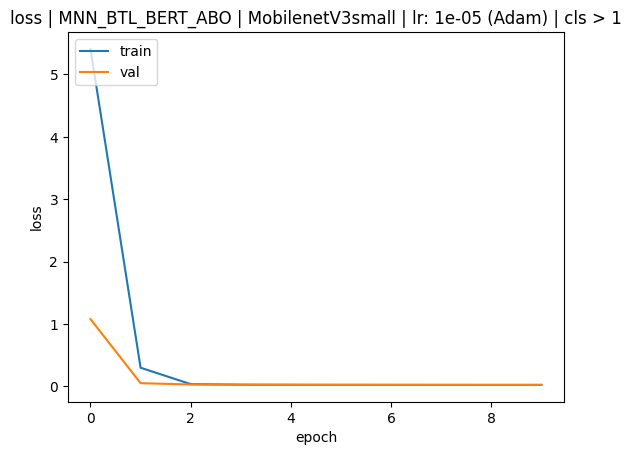

In [94]:
plot_metrics(history.history, [],
             model_name, img_model.name, optimizer_name, learning_rate,
             config["data"]["cls"])

## Evaluate model and save metrics

In [95]:
from utils.metrics import evaluate

In [96]:
test_merged = pd.concat([test.reset_index(drop=True), test_false.reset_index(drop=True)])
img_test_merged = np.concatenate([img_test, img_test_false])
text_test_merged = np.concatenate([text_test, text_test_false])
print(test_merged.shape, img_test_merged.shape, text_test_merged.shape)

(16808, 6) (16808, 576) (16808,)


In [97]:
evaluate(mnn_btl.model, [img_test_merged, text_test_merged], test_merged[["label"]], log_dir, model_name,
         img_model.name, optimizer_name, learning_rate, config["data"]["cls"], triplet_model=True)

16808/16808 [==============================] - 39s 2ms/step - loss: 0.0699
